## Import libraries, set path and load the face detector

In [62]:
# Connect with google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import os
import glob
from string import digits
import cv2
import dlib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [64]:
# tensorflow & keras version
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

TensorFlow version: 2.9.2
Keras version: 2.9.0


In [65]:
path = '/content/drive/MyDrive/spiced_projects/final_project/model_V3/'

In [66]:
# Download Dlib CNN face detector
#!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
#!bzip2 -dk mmod_human_face_detector.dat.bz2
#%rm mmod_human_face_detector.dat.bz2

# load the CNN face detector
path_facedetector = path + 'mmod_human_face_detector.dat'
dnnFaceDetector = dlib.cnn_face_detection_model_v1(path_facedetector)

##Load the model and create folders for classification and blurred images

In [67]:
classifier_model = tf.keras.models.load_model(path + 'saved_model/face_classifier_model.h5')

In [68]:
vgg_face = tf.keras.models.load_model(path + 'saved_model/vgg_face.h5', compile = False)

In [69]:
#class_rep = {1: 'adult', 0: 'toddler'}

In [70]:
# Path to folder which contains images to be tested and predicted
#test_images_path = path + 'test_images_unknown/'

In [71]:
isExist = os.path.exists(path + 'data/Classification')
if not isExist:
   os.mkdir(path + 'data/Classification')
   print("The new directory  " + path + 'data/Classification' + "  is created!")
else:
  print("The directory " + path + 'data/Classification' + " was already created!")

The directory /content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Classification was already created!


In [72]:
isExist = os.path.exists(path + 'data/Blur')
if not isExist:
   os.mkdir(path + 'data/Blur')
   print("The new directory  " + path + 'data/Blur' + "  is created!")
else:
  print("The directory " + path + 'data/Blur' + " was already created!")

The directory /content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Blur was already created!


##Classification time

In [73]:
def plot_predictions(img):
  plt.figure(figsize=(8,4))
  plt.imshow(img[:,:,::-1])
  plt.show()

In [74]:
def image_classification(file_path = os.listdir(path + 'data/test_images_unknown/')):      
  for img_name in file_path:
    if img_name == 'crop_img.jpg':
      continue
    # Load Image
    img = cv2.imread(path + 'data/test_images_unknown/' + img_name)

    print(path + 'data/test_images_unknown/' + img_name)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = dnnFaceDetector(gray,1)
    left,top,right,bottom = 0,0,0,0
    for (i,rect) in enumerate(rects):
      left   = rect.rect.left()   #x1
      top    = rect.rect.top()    #y1
      right  = rect.rect.right()  #x2
      bottom = rect.rect.bottom() #y2
      width  = right-left
      height = bottom-top
      img_crop = img[top:top+height,left:left+width]
      cv2.imwrite(path + 'data/test_images_unknown/crop_img.jpg',img_crop)
      
      # Get Embeddings
      crop_img = load_img(path + 'data/test_images_unknown/crop_img.jpg',target_size = (224,224))
      crop_img = img_to_array(crop_img)
      crop_img = np.expand_dims(crop_img,axis=0)
      crop_img = preprocess_input(crop_img)
      img_encode = vgg_face(crop_img)

      # Make Predictions
      embed = K.eval(img_encode)
      person = classifier_model.predict(embed)     
      if person[0] <= 0.5:
        name = 'child'
        person[0] = 1 - person[0]
      else:
        name = 'adult' 
        #name = 'spicy tutor' 
        person[0] = person[0]
      os.remove(path + 'data/test_images_unknown/crop_img.jpg')
      cv2.rectangle(img,(left,top),(right,bottom),(0,255,0), 2)
      img = cv2.putText(img,name,(left,top-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
      img = cv2.putText(img,str(np.max(person)),(right,bottom+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)

    # Save images with bounding box,name and accuracy 
    cv2.imwrite(path + 'data/Classification/' + img_name,img)
    print(path + 'data/Classification/' + img_name)
    plot_predictions(img)

/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/test_images_unknown/gb1.jpeg
1/1 [==============================] - 0s 14ms/step
/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Classification/gb1.jpeg


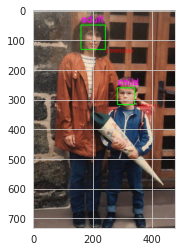

/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/test_images_unknown/gb3.jpeg
1/1 [==============================] - 0s 14ms/step
/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Classification/gb3.jpeg


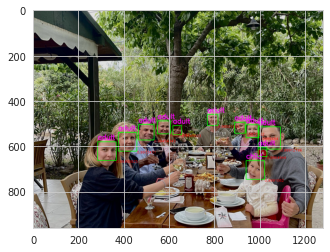

/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/test_images_unknown/gb4.jpg
1/1 [==============================] - 0s 14ms/step
/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Classification/gb4.jpg


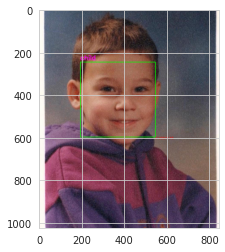

/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/test_images_unknown/gb6.jpg
1/1 [==============================] - 0s 15ms/step
/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Classification/gb6.jpg


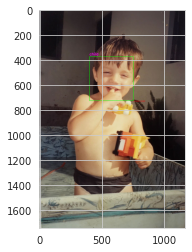

/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/test_images_unknown/gb5.jpg
1/1 [==============================] - 0s 15ms/step
/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Classification/gb5.jpg


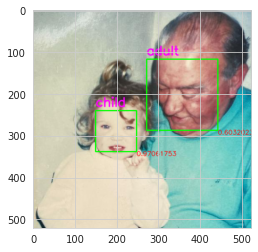

/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/test_images_unknown/gb2.jpg
1/1 [==============================] - 0s 16ms/step
/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Classification/gb2.jpg


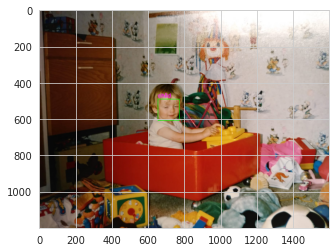

/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/test_images_unknown/gb7.jpg
1/1 [==============================] - 0s 14ms/step
/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Classification/gb7.jpg


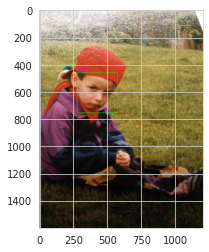

In [75]:
image_classification()




























































































































































































## Blur time

In [76]:
def image_blur(file_path = os.listdir(path + 'data/test_images_unknown/')):      
  for img_name in file_path:
    if img_name == 'crop_img.jpg':
      continue
    # Load Image
    img = cv2.imread(path + 'data/test_images_unknown/' + img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect Faces
    rects = dnnFaceDetector(gray,1)
    left,top,right,bottom = 0,0,0,0
    for (i,rect) in enumerate(rects):
      # Extract Each Face
      left   = rect.rect.left()   #x1
      top    = rect.rect.top()    #y1
      right  = rect.rect.right()  #x2
      bottom = rect.rect.bottom() #y2
      width  = right-left
      height = bottom-top
      img_crop = img[top:top+height,left:left+width]
      cv2.imwrite(path + 'data/test_images_unknown/crop_img.jpg',img_crop)
      
      # Get Embeddings
      crop_img = load_img(path + 'data/test_images_unknown/crop_img.jpg',target_size=(224,224))
      crop_img = img_to_array(crop_img)
      crop_img = np.expand_dims(crop_img,axis=0)
      crop_img = preprocess_input(crop_img)
      img_encode = vgg_face(crop_img)

      # Make Predictions
      embed = K.eval(img_encode)
      person = classifier_model.predict(embed)
      if person[0] <= 0.5:
        name = 'child'
      else:
        name = 'adult' 
      os.remove(path + 'data/test_images_unknown/crop_img.jpg')

      if name == 'child':
        blurred_part = cv2.blur(img[top:top+height,left:left+width], ksize=(20, 20), )
        img[top:top+height,left:left+width] = blurred_part
      else:
        img

    # Save images with bounding box,name and accuracy  
    cv2.imwrite(path + 'data/Blur/' + img_name,img)
    plot_predictions(img)

1/1 [==============================] - 0s 15ms/step


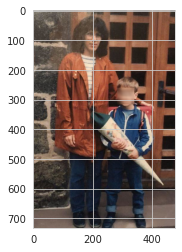

1/1 [==============================] - 0s 14ms/step


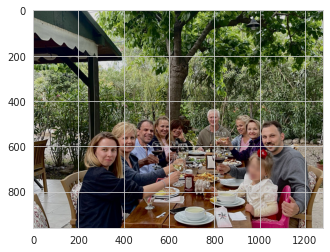

1/1 [==============================] - 0s 15ms/step


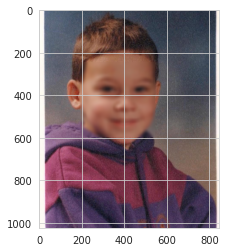

1/1 [==============================] - 0s 14ms/step


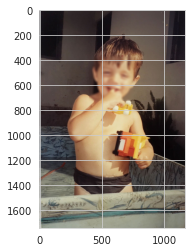

1/1 [==============================] - 0s 14ms/step


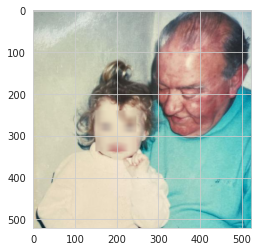

1/1 [==============================] - 0s 15ms/step


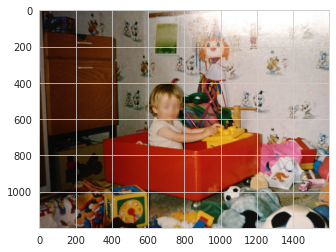

1/1 [==============================] - 0s 15ms/step


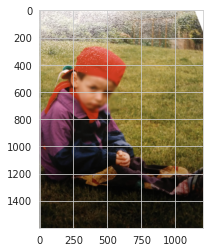

In [77]:
image_blur()

## Garlic Booster Photo - load

In [88]:
# https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=09b_0FAnUa9y

In [89]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [90]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [91]:
isExist = os.path.exists(path + 'data/Garlics')
if not isExist:
   os.mkdir(path + 'data/Garlics')
   print("The new directory  " + path + 'data/Garlics' + "  is created!")
else:
  print("The directory " + path + 'data/Garlics' + " was already created!")

The directory /content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Garlics was already created!


In [92]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [93]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  #print(gray.shape)
  # get face bounding box coordinates using Haar Cascade

  #     faces = face_cascade.detectMultiScale(gray)
  
  # draw face bounding box on image
  #      for (x,y,w,h) in faces:
  #             img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [94]:
def plot_predictions(img):
  plt.figure(figsize=(8,4))
  plt.imshow(img[:,:,::-1])
  plt.show()

In [95]:
def gb_classification(file_path = os.listdir(path + 'data/Garlics/')):      
  for img_name in file_path:
    if img_name == 'crop_img.jpg':
      continue
    # Load Image
    img = cv2.imread(path + 'data/Garlics/' + img_name)

    print(path + 'data/Garlics/' + img_name)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = dnnFaceDetector(gray,1)
    left,top,right,bottom = 0,0,0,0
    for (i,rect) in enumerate(rects):
      left   = rect.rect.left()   #x1
      top    = rect.rect.top()    #y1
      right  = rect.rect.right()  #x2
      bottom = rect.rect.bottom() #y2
      width  = right-left
      height = bottom-top
      img_crop = img[top:top+height,left:left+width]
      cv2.imwrite(path + 'data/Garlics/crop_img.jpg',img_crop)
      
      # Get Embeddings
      crop_img = load_img(path + 'data/Garlics/crop_img.jpg',target_size = (224,224))
      crop_img = img_to_array(crop_img)
      crop_img = np.expand_dims(crop_img,axis=0)
      crop_img = preprocess_input(crop_img)
      img_encode = vgg_face(crop_img)

      # Make Predictions
      embed = K.eval(img_encode)
      person = classifier_model.predict(embed)     
      if person[0] <= 2.0:
        name = '100% Garlic Booster'
      else:
        name = '' 
      os.remove(path + 'data/Garlics/crop_img.jpg')
      cv2.rectangle(img,(left,top),(right,bottom),(0,255,0), 1)
      img = cv2.putText(img,name,(left,top-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),1,cv2.LINE_AA)
      #img = cv2.putText(img),(right,bottom+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)

    # Save images with bounding box,name and accuracy 
    cv2.imwrite(path + 'data/Garlics/' + img_name,img)
    print(path + 'data/Garlics/' + img_name)
    plot_predictions(img)

## Take picture of Garlic Boosters

<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Garlics/garlicbooster.jpeg


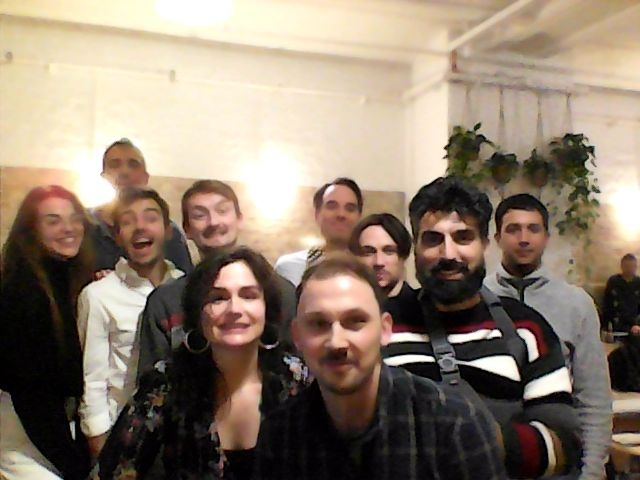

In [86]:
try:
  filename = take_photo(path + 'data/Garlics/garlicbooster.jpeg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Classification!

/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Garlics/garlicbooster.jpeg
1/1 [==============================] - 0s 14ms/step
/content/drive/MyDrive/spiced_projects/final_project/model_V3/data/Garlics/garlicbooster.jpeg


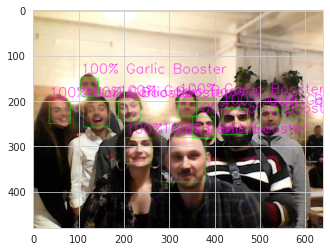

In [96]:
gb_classification()